In [15]:
from lib.main_func_p1 import path, timer
import pandas as pd
from importlib import reload
from collections import OrderedDict
import lib.main_func_p4
from lib.main_func_p4 import modelXGBoost_fit_scores


#XGBoost library
import xgboost as xgb


In [16]:
# proteina (uniprot_ID)
uniprot_id = 'P56817'
excel_name = 'P56817_20220603101021_top_scores_XGBClassifier_accuracy_rf4'
path_file = path(uniprot_id)
# Parametros
seed = 142857
fp_name = 'morgan2_c'

In [17]:
# Load top_scores
top_scores = pd.read_excel(f'./top_scores/{excel_name}.xlsx')

# Best calibration scores
top_socres_len = 15
top_scores_top = top_scores.iloc[:top_socres_len]
top_scores_top_index_list = top_scores_top.index
top_scores

,model,params_dict,AUC_train,AUC_valid,accuracy_train,accuracy_valid,recall_train,recall_valid,specificity_train,specificity_valid,precision_train,precision_valid,f1_score_train,f1_score_valid,conf_matrix_train,conf_matrix_valid,calibration_score
0,modelID_310,"OrderedDict([('alpha', 0.5), ('gamma', 0.0), (...",0.996,0.956,0.986,0.947,0.996,0.986,0.925,0.708,0.989,0.954,0.986,0.945,"[[631, 48], [18, 4150]]","[[85, 35], [10, 726]]",0.011544
1,modelID_470,"OrderedDict([('alpha', 0.3), ('gamma', 0.0), (...",0.995,0.950,0.984,0.946,0.995,0.985,0.916,0.707,0.986,0.954,0.984,0.944,"[[622, 57], [21, 4147]]","[[85, 35], [11, 725]]",0.012640
2,modelID_396,"OrderedDict([('alpha', 0.3), ('gamma', 0.0), (...",0.996,0.955,0.986,0.943,0.996,0.985,0.925,0.685,0.987,0.950,0.985,0.940,"[[626, 53], [17, 4151]]","[[82, 38], [11, 725]]",0.012720
3,modelID_481,"OrderedDict([('alpha', 0.5), ('gamma', 0.0), (...",0.995,0.957,0.984,0.946,0.995,0.984,0.916,0.713,0.986,0.955,0.983,0.944,"[[619, 60], [19, 4149]]","[[86, 34], [12, 724]]",0.012770
4,modelID_259,"OrderedDict([('alpha', 0.2), ('gamma', 0.0), (...",0.995,0.958,0.984,0.939,0.996,0.984,0.910,0.663,0.986,0.948,0.984,0.936,"[[619, 60], [18, 4150]]","[[80, 40], [12, 724]]",0.012913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,modelID_109,"OrderedDict([('alpha', 0.1), ('gamma', 0.1), (...",0.980,0.949,0.934,0.909,1.000,0.996,0.529,0.375,0.929,0.907,0.925,0.891,"[[361, 318], [2, 4166]]","[[45, 75], [3, 733]]",0.048819
496,modelID_24,"OrderedDict([('alpha', 0.1), ('gamma', 1.5), (...",0.972,0.939,0.934,0.911,0.999,0.996,0.535,0.390,0.929,0.909,0.925,0.895,"[[361, 318], [4, 4164]]","[[47, 73], [3, 733]]",0.049567
497,modelID_0,"OrderedDict([('alpha', 0.3), ('gamma', 0.7), (...",0.977,0.948,0.932,0.904,0.999,0.997,0.521,0.334,0.927,0.902,0.923,0.884,"[[352, 327], [3, 4165]]","[[40, 80], [2, 734]]",0.051390
498,modelID_1,"OrderedDict([('alpha', 0.5), ('gamma', 1.0), (...",0.974,0.940,0.932,0.903,1.000,0.999,0.515,0.314,0.927,0.900,0.922,0.881,"[[350, 329], [2, 4166]]","[[38, 82], [1, 735]]",0.052237


In [22]:
reload(lib.main_func_p4)
from lib.main_func_p4 import modelXGBoost_fit_scores
# Load train and validation datasets
df_train = pd.read_pickle(f'{path_file}_dataset_train')
df_valid = pd.read_pickle(f'{path_file}_dataset_valid')

new_row_list = list()
results_ROF_list_train = list()
results_ROF_list_valid = list()
df_list = list()
plots_name_list = list()

for i, params_dict in enumerate(top_scores.params_dict.iloc[0:top_socres_len]):
    eval_metric = ['error', 'auc']
    tick = timer()
    params_dict_Orderer = params_dict
    params_dict = dict(eval(params_dict))
    default_params_xgb = {'booster': 'gbtree', 'tree_method': 'gpu_hist',
                          'objective':'binary:logistic', 'grow_policy': 'depthwise',
                          'eval_metric': eval_metric, 'early_stopping_rounds':10}
    params_dict.update(default_params_xgb)


    xgb_clf = xgb.XGBClassifier(**params_dict)

    # Train model and evaluating scores (train / validation)
    xgb_clf, scores_train, scores_valid = modelXGBoost_fit_scores(xgb_clf, fp_name, df_train, df_valid,
                                                                  resample_factor=4,
                                                                  resample_mode='under_sampling')

    if i == 0:
        xgb_clf.save_model(f'./models/{uniprot_id}_model.ubj')
        print(f'Best model saved ({top_scores.model.iloc[i]})')

    # ROF results
    results_ROF_list_train.append(scores_train[7])
    results_ROF_list_valid.append(scores_valid[7])

    # save pred and pred_prob of train set
    df = df_train[['activity', 'prediction', 'prediction_prob']].copy()
    df_list.append(df)

    plots_name_list.append(top_scores.model.iloc[i])
    print(f'{i+1}/{top_socres_len}. {top_scores.model.iloc[i]}. AUC_socre=(train={scores_train[0]},'
          f' valid={scores_valid[0]}). Time elapsed: {timer(tick)}')

under_sampling - 4: 4847 to 3395
Best model saved (modelID_310)
1/15. modelID_310. AUC_socre=(train=0.988, valid=0.954). Time elapsed: 3.5 seconds.
under_sampling - 4: 4847 to 3395
2/15. modelID_470. AUC_socre=(train=0.987, valid=0.952). Time elapsed: 3.1 seconds.
under_sampling - 4: 4847 to 3395
3/15. modelID_396. AUC_socre=(train=0.989, valid=0.949). Time elapsed: 3.6 seconds.
under_sampling - 4: 4847 to 3395
4/15. modelID_481. AUC_socre=(train=0.988, valid=0.952). Time elapsed: 4.1 seconds.
under_sampling - 4: 4847 to 3395
5/15. modelID_259. AUC_socre=(train=0.992, valid=0.958). Time elapsed: 4.0 seconds.
under_sampling - 4: 4847 to 3395
6/15. modelID_121. AUC_socre=(train=0.988, valid=0.949). Time elapsed: 3.9 seconds.
under_sampling - 4: 4847 to 3395
7/15. modelID_211. AUC_socre=(train=0.99, valid=0.954). Time elapsed: 4.1 seconds.
under_sampling - 4: 4847 to 3395
8/15. modelID_392. AUC_socre=(train=0.985, valid=0.953). Time elapsed: 3.5 seconds.
under_sampling - 4: 4847 to 3395
9

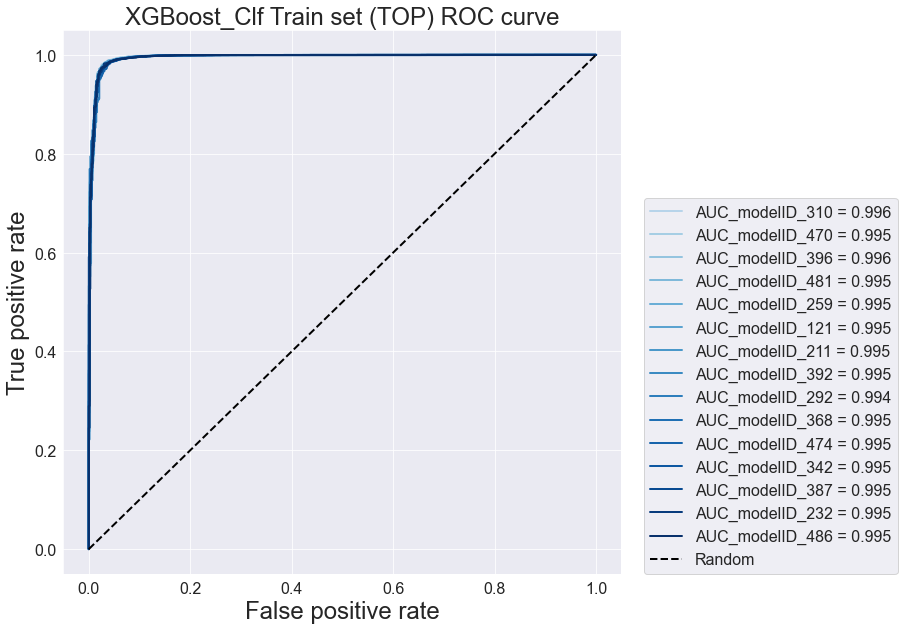

In [19]:
# ROC curve - best scores
reload(lib.main_func_p4)
from lib.main_func_p4 import plot_ROC_curve
results_ROF_train_list_top = list()
results_ROF_valid_list_top = list()
ROC_plots_name_top_name = list()
for i in top_scores_top_index_list:
    results_ROF_train_list_top.append(results_ROF_list_train[i])
    results_ROF_valid_list_top.append(results_ROF_list_valid[i])
    ROC_plots_name_top_name.append(plots_name_list[i])

model_name = f'XGBoost_Clf Train set (TOP)'
plot_ROC_curve(results_ROF_train_list_top, ROC_plots_name_top_name, model_name,
               path_file=path_file, name_mod="train_Top_score", save_fig=True)

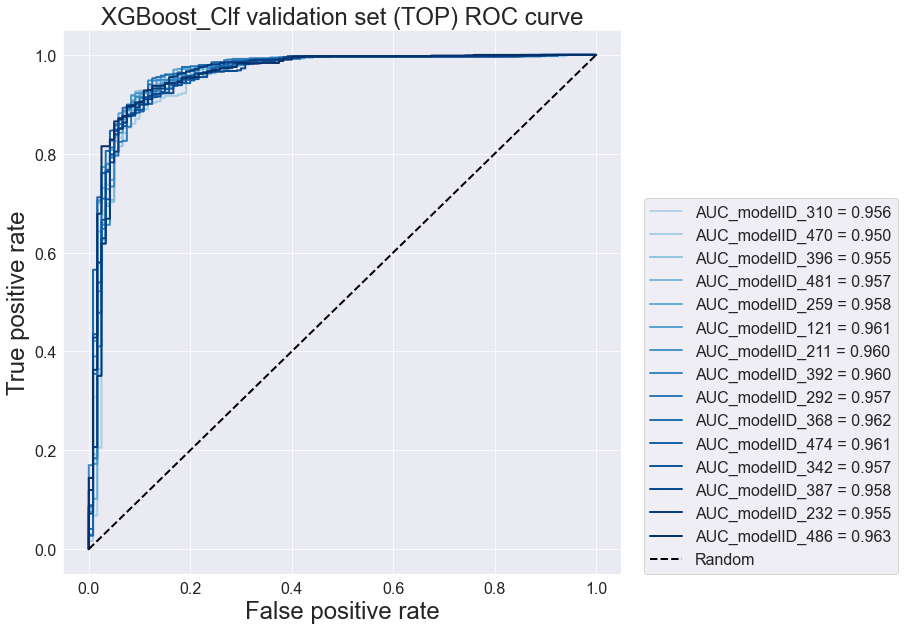

In [20]:
model_name = f'XGBoost_Clf validation set (TOP)'
plot_ROC_curve(results_ROF_valid_list_top, ROC_plots_name_top_name, model_name,
               path_file=path_file, name_mod="validation_Top_score", save_fig=True)

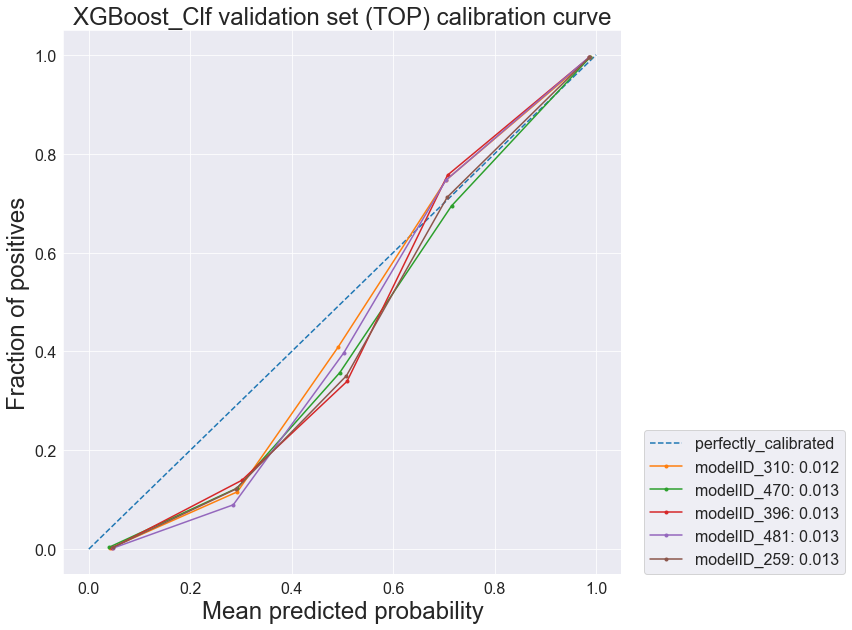

In [21]:
# Calibration curve - best scores (10)
reload(lib.main_func_p4)
from lib.main_func_p4 import plot_calibration_curve
df_list_top = list()
df_list_top_name = list()

# Only graph top 5
for i in top_scores_top_index_list:
    df_list_top.append(df_list[i])
    df_list_top_name.append((plots_name_list[i]))
plot_calibration_curve(df_list_top[:5], df_list_top_name[:5], model_name,
                       path_file=path_file, name_mod="validation_Top_score", save_fig=True)